## 1. Answer to the questions from introduction
1. What is leave-one-out? Provide limitations and strong sides
    - является частным случаем метода k-Fold: в нём каждый фолд состоит ровно из одного семпла.
    - понадобиться в случае, если очень мало данных (например, в задаче сегментации клеток на изображениях с оптического микроскопа) и вы хотите использовать максимальное их количество для обучения модели: для валидации на каждой итерации методу требуется всего один семпл.
    - Однако и итераций будет столько, сколько семплов в данных, поэтому метод неприменим для средних и больших задач.
2. How Grid Search, Randomized Grid Search and Bayesian optimization works?
    - GS:
        1. для каждого гиперпараметра фиксируется несколько значений;
        2. перебираются все комбинации значений различных гиперпараметров, на каждой из этих комбинаций модель обучается и тестируется;
        3. выбирается комбинация, на которой модель показывает лучшее качество.

    - RGS:
        - перебирать не все комбинации гиперпараметров, а только случайное подмножество
    - BO:
        - это итерационный метод, позволяющий оценить оптимум функции, не дифференцируя её. Кроме того, на каждой итерации метод указывает, в какой следующей точке мы с наибольшей вероятностью улучшим нашу текущую оценку оптимума.
        - хорошо работает, когда нужно оптимизировать небольшое число гиперпараметров, так как в наивной реализации алгоритм не поддаётся распараллеливанию. При большой размерности пространства гиперпараметров скорость сходимости не лучше, чем у обычного Random Search
3. Explain the classification of feature selection methods. Explain how Pearson and Chi2 works. Explain how Lasso works.  
    - Методы выделения признаков можно разделить на несколько категорий в зависимости от их подхода и цели. Вот основные категории:

        1. Методы фильтрации: Эти методы отбирают признаки на основе статистических показателей или оценок, рассчитанных на основе данных, без использования конкретного алгоритма машинного обучения. В качестве примеров можно привести отбор признаков на основе корреляции, тест хи-квадрат, SelectKBest и F-значение ANOVA.

        2. Обертывающие методы: Обертывающие методы оценивают подмножества признаков путем обучения и тестирования определенного алгоритма машинного обучения. Они выбирают признаки, основываясь на производительности модели. Примеры: рекурсивное исключение признаков, обратное исключение признаков и прямой отбор признаков.

        3. Встроенные методы: Встроенные методы включают отбор признаков в сам алгоритм обучения. Эти методы определяют важность признаков в процессе обучения модели. В качестве примеров можно привести регрессию Лассо, регрессию Риджа и Random Forest.

        4. Гибридные методы: гибридные методы сочетают в себе сильные стороны методов фильтрации и обертывания. Они используют комбинацию статистических показателей и алгоритмов машинного обучения для выбора признаков.

    - Корреляция Пирсона - это мера линейной связи между двумя переменными. [-1,1]. Она предполагает, что обе переменные нормально распределены. Она измеряет только линейную корреляцию между переменными, игнорируя любые нелинейные связи.
    - Тест хи-квадрат широко используется при отборе признаков для выявления наиболее информативных категориальных признаков. Он рассчитывает метрику хи-квадрат между целевой и категориальной переменной и выбирает нужное количество переменных с наилучшими значениями хи-квадрат.
    - лассо зануляет веса признаков которые линейно зависят с существующими

4. Explain what is permutation importance. Get acquainted with SHAP
    - permutation importance: Произвольным образом переставить или перетасовать один столбец в наборе датасета валидации, оставив все остальные столбцы нетронутыми. Признак считается «важным», если точность модели падает и его изменение вызывает увеличение ошибок. С другой стороны, признак считается «неважным», если перетасовка его значений не влияет на точность модели
    - Библиотека SHAP (SHapley Additive exPlanations)  используется для объяснения работы моделей машинного обучения и интерпретации их предсказаний. Она предоставляет инструменты для вычисления значимости признаков в модели и позволяет понять, как каждый признак влияет на предсказания

# 2. Introduction  - make all preprocess staff from the previous lesson

In [387]:
! pip install scikit-learn statsmodels matplotlib seaborn shap optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.1 MB/s eta 0:00:00


In [ ]:
! pip install kaggle
! mkdir .kaggle data
! chmod 600 .kaggle/kaggle.json
! kaggle competitions download two-sigma-connect-rental-listing-inquiries
! unzip two-sigma-connect-rental-listing-inquiries.zip
! unzip data/train.json.zip
! unzip data/test.json.zip

In [399]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import optuna
import re
import math
import shap

In [392]:
import warnings
warnings.filterwarnings('ignore')

## 2.1 Read all data – data.csv.

In [321]:
df = pd.read_json('data/train.json')
df.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium


In [322]:
df.isnull().mean()

bathrooms          0.0
bedrooms           0.0
building_id        0.0
created            0.0
description        0.0
display_address    0.0
features           0.0
latitude           0.0
listing_id         0.0
longitude          0.0
manager_id         0.0
photos             0.0
price              0.0
street_address     0.0
interest_level     0.0
dtype: float64

## 2.2 Preprocess “interest level” feature.

In [323]:
df['interest_level'] = df['interest_level'].astype('category').cat.codes
df['interest_level'].value_counts()

1    34284
2    11229
0     3839
Name: interest_level, dtype: int64

## 2.3 Create features:  
'Elevator', 'HardwoodFloors', 'CatsAllowed', 'DogsAllowed', 'Doorman', 'Dishwasher', 'NoFee', 'LaundryinBuilding', 'FitnessCenter', 'Pre-War', 'LaundryinUnit', 'RoofDeck', 'OutdoorSpace', 'DiningRoom', 'HighSpeedInternet', 'Balcony', 'SwimmingPool', 'LaundryInBuilding', 'NewConstruction', 'Terrace'

In [324]:
df['features'] = df['features'].apply(lambda x: list([re.sub(r'[\[\]\'\"\s]', '', item) for item in x]))

In [325]:
top_20_features = ['Elevator',
                   'HardwoodFloors',
                   'CatsAllowed',
                   'DogsAllowed',
                   'Doorman',
                   'Dishwasher',
                   'NoFee',
                   'LaundryinBuilding',
                   'FitnessCenter',
                   'Pre-War',
                   'LaundryinUnit',
                   'RoofDeck',
                   'OutdoorSpace',
                   'DiningRoom',
                   'HighSpeedInternet',
                   'Balcony',
                   'SwimmingPool',
                   'LaundryInBuilding',
                   'NewConstruction',
                   'Terrace']

In [326]:
def onehotencoder(df, features_list):
  result = np.zeros((len(df), len(features_list)))
  for r, col in enumerate(df):
    for fi in range(len(features_list)):
      for c in col:
        if features_list[fi] == c:
          result[r, fi] = 1
  return result

In [327]:
df_encoded = pd.DataFrame(onehotencoder(df['features'], top_20_features))
rename_dict = dict(zip(range(20), top_20_features))
df_encoded = df_encoded.rename(columns=rename_dict)

In [328]:
df_enriched = pd.concat([df.reset_index(), df_encoded.reset_index()], axis=1).drop(['index'], axis=1)
df_enriched.head(5)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,LaundryinUnit,RoofDeck,OutdoorSpace,DiningRoom,HighSpeedInternet,Balcony,SwimmingPool,LaundryInBuilding,NewConstruction,Terrace
0,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[DiningRoom, Pre-War, LaundryinBuilding, Dishw...",40.7108,7170325,-73.9539,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, LaundryinBuilding, Dishwas...",40.7513,7092344,-73.9722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, LaundryinBuilding, Laundry...",40.7575,7158677,-73.9625,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, FitnessCenter, LaundryinBu...",40.7439,7225292,-73.9743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [329]:
df_enriched.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude', 'listing_id', 'longitude',
       'manager_id', 'photos', 'price', 'street_address', 'interest_level',
       'Elevator', 'HardwoodFloors', 'CatsAllowed', 'DogsAllowed', 'Doorman',
       'Dishwasher', 'NoFee', 'LaundryinBuilding', 'FitnessCenter', 'Pre-War',
       'LaundryinUnit', 'RoofDeck', 'OutdoorSpace', 'DiningRoom',
       'HighSpeedInternet', 'Balcony', 'SwimmingPool', 'LaundryInBuilding',
       'NewConstruction', 'Terrace'],
      dtype='object')

In [330]:
df_enriched = df_enriched.drop(['building_id',
                                'description',
                                'display_address',
                                'listing_id',
                                'manager_id',
                                'photos',
                                'street_address',
                                'features',
                                'latitude',
                                'longitude'], axis=1)

In [331]:
df_enriched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49352 entries, 0 to 49351
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bathrooms          49352 non-null  float64
 1   bedrooms           49352 non-null  int64  
 2   created            49352 non-null  object 
 3   price              49352 non-null  int64  
 4   interest_level     49352 non-null  int8   
 5   Elevator           49352 non-null  float64
 6   HardwoodFloors     49352 non-null  float64
 7   CatsAllowed        49352 non-null  float64
 8   DogsAllowed        49352 non-null  float64
 9   Doorman            49352 non-null  float64
 10  Dishwasher         49352 non-null  float64
 11  NoFee              49352 non-null  float64
 12  LaundryinBuilding  49352 non-null  float64
 13  FitnessCenter      49352 non-null  float64
 14  Pre-War            49352 non-null  float64
 15  LaundryinUnit      49352 non-null  float64
 16  RoofDeck           493

# 3. Implement next methods:

## 3.1 Split data into 2 parts randomly with parameter test_size (ratio from 0 to 1), return train and test samples

In [332]:
def train_test_split_2(df, test_size):
    assert test_size < 1 and test_size > 0
    df_shuffled = df.sample(frac=1).reset_index(drop=True)
    n = math.ceil(df.shape[0]*test_size)
    return df_shuffled.iloc[n:,:], df_shuffled.iloc[:n,:]

In [333]:
train, test = train_test_split_2(df_enriched, test_size=0.2)
print(f'ORIGIN shape:{df_enriched.shape} \n TRAIN shape:{train.shape} \n  TEST shape:{test.shape}')

ORIGIN shape:(49352, 25) 
 TRAIN shape:(39481, 25) 
  TEST shape:(9871, 25)


In [334]:
train, test = train_test_split(df_enriched, test_size=0.2)
print(f'ORIGIN shape:{df_enriched.shape} \n TRAIN shape:{train.shape} \n  TEST shape:{test.shape}')

ORIGIN shape:(49352, 25) 
 TRAIN shape:(39481, 25) 
  TEST shape:(9871, 25)


## 3.2 Split data into 3 parts randomly with parameters validation_size and  test_size, return train, validation and test samples

In [335]:
def train_validation_test_split(df, validation_size, test_size):
    assert test_size < 1 and test_size > 0 and validation_size < 1 and validation_size > 0
    df_shuffled = df.sample(frac=1).reset_index(drop=True)
    n_v = math.ceil(df.shape[0]*validation_size)
    n = n_v + math.ceil(df.shape[0]*test_size)
    return df_shuffled.iloc[n:,:], df_shuffled.iloc[:n_v,:], df_shuffled.iloc[n_v:n,:]

In [336]:
train, validation, test = train_validation_test_split(df_enriched, validation_size=0.3, test_size=0.2)
print(f'    ORIGIN shape:{df_enriched.shape} \n     TRAIN shape:{train.shape}\nVALIDATION shape:{validation.shape} \n      TEST shape:{test.shape}')

    ORIGIN shape:(49352, 25) 
     TRAIN shape:(24675, 25)
VALIDATION shape:(14806, 25) 
      TEST shape:(9871, 25)


## 3.3 Split data into 2 parts with parameter date_split, return train and test samples splitted by date_split param

In [337]:
def train_test_split_date(df: pd.DataFrame, date_col: str, date_split: str):
    return df[df[date_col] < date_split], df[df[date_col] >= date_split]

In [338]:
train, test = train_test_split_date(df_enriched, 'created', '2016-04-29')

In [339]:
train.created.max()

'2016-04-28 23:41:55'

In [340]:
test.created.min()

'2016-04-29 00:48:39'

## 3.4 Split data into 3 parts with parameters validation_date and  test_date, return train, validation and test samples  splitted by input params

In [341]:
def train_validation_test_split_date(df: pd.DataFrame, date_col: str, validation_date: str, test_date: str):
    return df[df[date_col] < validation_date], df[(df[date_col] >= validation_date) & (df[date_col] < test_date)], df[df[date_col] >= test_date]

In [342]:
train, validation, test = train_validation_test_split_date(df_enriched, 'created', '2016-04-29', '2016-05-29')

In [343]:
train.created.max()

'2016-04-28 23:41:55'

In [344]:
validation.created.max()

'2016-05-28 20:52:19'

In [345]:
test.created.max()

'2016-06-29 21:41:47'

# 4. Implement next cross validation methods:

## 4.1 K-fold, where k is input parameter, return list of train and test indexes

In [346]:
def kfold(df, k=2):
    assert k > 1
    size = math.ceil(df.shape[0]/k)
    res_list = [i for i in range(0, df.shape[0], size)]
    res_list.append(df.shape[0])
    result_arrays =[]
    # print(res_list)
    for i in range(len(res_list)-1):
        result_arrays.append(np.array([i for i in range(0, res_list[i])]
                                      + [i for i in range(res_list[i+1], res_list[len(res_list)-1])])) # train
        result_arrays.append(np.arange(res_list[i], res_list[i+1]))  # test
    return result_arrays

## 4.2 Grouped K-fold, where k and group_field are input parameter, return list of train and test indexes

сплитов максимум столько сколько групп, меньше чем групп может быть

In [347]:
def grouped_kfold(df, group_field, k=2):
    assert k > 1 and k <= df[group_field].nunique()
    df.sort_values(by=[group_field])
    group_list = []
    sum=0
    for i in df[group_field].value_counts():
        group_list.append(sum+i-1)
        sum += i
    # print("group_list: ", group_list)
    res_list = [0]
    if k < df[group_field].nunique():
        size = math.ceil(df.shape[0]/k)
        size_list = [i for i in range(0, df.shape[0], size)]
        size_list.remove(0)
        # print("size_list: ", size_list)
        for i in range(0, k-1):
            closest_value = min(group_list, key=lambda x: abs(x - size_list[i]))
            res_list.append(closest_value)
            group_list.remove(closest_value)
        res_list.append(df.shape[0])
    else:
        res_list += group_list
    # print("res_list: ", res_list)

    result_arrays =[]
    for i in range(len(res_list)-1):
        result_arrays.append(np.array([i for i in range(0, res_list[i])]
                                      + [i for i in range(res_list[i+1], res_list[len(res_list)-1])])) # train
        result_arrays.append(np.arange(res_list[i], res_list[i+1]))  # test
    return result_arrays

## 4.3 Stratified K-fold, where k and stratify_field are input parameter, return list of train and test indexes

In [348]:
import itertools

def stratified_kfold(df, strata, k=2):
    assert k > 1
    dict_idxes = {}
    dict_sizes = {}
    for i in strata.unique():
        dict_idxes[i] = df.index[df['interest_level'] == i].tolist()
        dict_sizes[i] = round(df.index[df['interest_level'] == i].size/k)
    size = round(df.shape[0]/k)
    result_arrays =[]
    # print(res_list)
    for j in range(k):
        arr_train = (list([dict_idxes[i][:j*dict_sizes[i]] for i in dict_idxes.keys()]) +
                    list([dict_idxes[i][(j+1)*dict_sizes[i]:] for i in dict_idxes.keys()]))
        arr_train = list(itertools.chain(*arr_train))
        result_arrays.append(np.array(arr_train)) # train
        arr_test = list([dict_idxes[i][j*dict_sizes[i]:(j+1)*dict_sizes[i]] for i in dict_idxes.keys()])
        arr_test = list(itertools.chain(*arr_test))
        result_arrays.append(np.array(arr_test))  # test
    return result_arrays

## 4.4 Time series split, where k and date_field are input parameter, return list of train and test indexes

In [349]:
def time_series_split(df, date_field=None, k=2):
    assert k > 1
    if date_field != None:
        df_sorted = df.sort_values(by=[date_field])
    else:
        df_sorted = df
    size = math.ceil(df.shape[0]/(k+1))
    result_arrays =[]
    sup = k
    for i in range(k):
        result_arrays.append(np.array(df_sorted.index[:(i+1)*size].tolist())) # train
        result_arrays.append(np.array(df_sorted.index[(i+1)*size:(i+2)*size].tolist()))  # test
    return result_arrays

# 5. Cross-validation comparison

## 5.1 Apply all implemented validation methods from above to our dataset.

## 5.2 Apply the corresponding methods from sklearn.

## 5.3 Compare the resulting distributions of features for the training part of the dataset between sklearn and your own implementation.

In [350]:
for i in kfold(df_enriched, 3):
    print(i, len(i))

[16451 16452 16453 ... 49349 49350 49351] 32901
[    0     1     2 ... 16448 16449 16450] 16451
[    0     1     2 ... 49349 49350 49351] 32901
[16451 16452 16453 ... 32899 32900 32901] 16451
[    0     1     2 ... 32899 32900 32901] 32902
[32902 32903 32904 ... 49349 49350 49351] 16450


In [351]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)
for train, test in kf.split(df_enriched):
    print("%s %s\n%s %s" % (train, len(train), test, len(test)))

[16451 16452 16453 ... 49349 49350 49351] 32901
[    0     1     2 ... 16448 16449 16450] 16451
[    0     1     2 ... 49349 49350 49351] 32901
[16451 16452 16453 ... 32899 32900 32901] 16451
[    0     1     2 ... 32899 32900 32901] 32902
[32902 32903 32904 ... 49349 49350 49351] 16450


In [352]:
for i in grouped_kfold(df_enriched, 'interest_level', 3):
    print(i, len(i))

[34283 34284 34285 ... 49348 49349 49350] 15068
[    0     1     2 ... 34280 34281 34282] 34283
[    0     1     2 ... 49348 49349 49350] 38122
[34283 34284 34285 ... 45509 45510 45511] 11229
[    0     1     2 ... 45509 45510 45511] 45512
[45512 45513 45514 ... 49348 49349 49350] 3839


In [353]:

from sklearn.model_selection import GroupKFold

gkf = GroupKFold(n_splits=3)

for train, test in gkf.split(df_enriched, groups=df_enriched.interest_level):
    print("%s %s\n%s %s" % (train, len(train), test, len(test)))

[    0     2     3 ... 49349 49350 49351] 15068
[    1     4     5 ... 49345 49346 49347] 34284
[    1     4     5 ... 49346 49347 49351] 38123
[    0     2     3 ... 49348 49349 49350] 11229
[    0     1     2 ... 49348 49349 49350] 45513
[    7    17    31 ... 49312 49341 49351] 3839


In [354]:
for i in stratified_kfold(df_enriched,df_enriched['interest_level'], 4):
    print(i, len(i))

[12493 12494 12503 ... 49312 49341 49351] 37014
[    0     2     3 ... 12333 12344 12347] 12338
[    0     2     3 ... 49312 49341 49351] 37014
[12493 12494 12503 ... 24446 24448 24454] 12338
[    0     2     3 ... 49312 49341 49351] 37014
[24899 24903 24904 ... 36540 36558 36560] 12338
[    0     2     3 ... 36558 36560 49350] 37015
[37136 37137 37140 ... 49312 49341 49351] 12337


In [355]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=4) # 2 и более

for train_index, test_index in skf.split(df_enriched.drop(['interest_level'], axis=1), df_enriched['interest_level']):
    print("%s %s\n%s %s" % (train, len(train), test, len(test)))

[    0     1     2 ... 49348 49349 49350] 45513
[    7    17    31 ... 49312 49341 49351] 3839
[    0     1     2 ... 49348 49349 49350] 45513
[    7    17    31 ... 49312 49341 49351] 3839
[    0     1     2 ... 49348 49349 49350] 45513
[    7    17    31 ... 49312 49341 49351] 3839
[    0     1     2 ... 49348 49349 49350] 45513
[    7    17    31 ... 49312 49341 49351] 3839


In [356]:
for i in time_series_split(df_enriched, 'created', 3):
    print(i, len(i))

[44454 46931 45569 ... 33984 42832 38871] 12338
[48900 46458 43079 ... 25422 20458 22549] 12338
[44454 46931 45569 ... 25422 20458 22549] 24676
[25023 21022 17813 ... 11600  2810 16820] 12338
[44454 46931 45569 ... 11600  2810 16820] 37014
[ 3072 12873  6226 ...   247 13840 11297] 12338


In [357]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)
for train, test in tscv.split(df_enriched):
    print("%s %s\n%s %s" % (train, len(train), test, len(test)))

[    0     1     2 ... 12335 12336 12337] 12338
[12338 12339 12340 ... 24673 24674 24675] 12338
[    0     1     2 ... 24673 24674 24675] 24676
[24676 24677 24678 ... 37011 37012 37013] 12338
[    0     1     2 ... 37011 37012 37013] 37014
[37014 37015 37016 ... 49349 49350 49351] 12338


## 5.4 Compare all validation schemes. Choose the best one. Explain your choice.

ответ зависит от ситуации:
1. При рандомном датасете лучше обычный сплит
2. Если известно что есть группы и хотим присуствие каждой в трейн и тест, то лучше стратифицированный сплит
3. Если хотим чтобы группы были отдельно в трейн и тест, то лучше кфолд сплит
4. Если известно что временной ряд присуствует то лучше тайм сплит

# 6. Feature selection

## 6.1 Fit lasso regression model with normalized features. Use your method for split samples into 3 parts by field created with ratio 60/20/20 – train/validation/test.

Normalization

In [358]:
selected_columns = ['bathrooms', 'bedrooms']

X_selected = df_enriched[selected_columns]

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_selected)

df_enriched[selected_columns] = X_normalized

Split

In [359]:
train, validation, test = train_validation_test_split_date(df_enriched, 'created', '2016-05-25', '2016-06-12')
size = df_enriched.shape[0]
print(len(train)/size, len(validation)/size, len(test)/size)

0.5999756848759928 0.1917855406062571 0.20823877451775005


In [360]:
X_train = train.drop(["price", "created"], axis=1)
y_train = train['price']

X_val = validation.drop(["price", "created"], axis=1)
y_val = validation['price']

X_test = test.drop(["price", "created"], axis=1)
y_test = test['price']

In [361]:
%%time
lasso = Lasso()
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
print(f"MAE:  {(mae):.2f}")
print(f"RMSE: {(rmse):.2f}")
print(f"R2:   {(r2):.5f}")

MAE:  914.67
RMSE: 1983.11
R2:   0.44546
CPU times: user 86.3 ms, sys: 52.5 ms, total: 139 ms
Wall time: 222 ms


To save the result

In [362]:
result_MAE = pd.DataFrame({'model': [], 'validation': [], 'test': []})
result_RMSE = pd.DataFrame({'model': [], 'validation': [], 'test': []})
result_R2 = pd.DataFrame({'model': [], 'validation': [], 'test': []})

In [363]:
result_MAE.loc[len(result_MAE)] = ['lasso_default', mae, mean_absolute_error(y_test, lasso.predict(X_test))]
result_RMSE.loc[len(result_RMSE)] = ['lasso_default', rmse, np.sqrt(mean_squared_error(y_test, lasso.predict(X_test)))]
result_R2.loc[len(result_R2)] = ['lasso_default', r2, r2_score(y_test, lasso.predict(X_test))]

## 6.2 Sort features by weight coefficients from model, refit model on top 10 features and compare quality.

In [364]:
%%time
sorted_indices = np.argsort(lasso.coef_)
top_10_indices = sorted_indices[-10:]

X_train_top_10 = X_train.iloc[:, top_10_indices]
X_val_top_10 = X_val.iloc[:, top_10_indices]
X_test_top_10 = X_test.iloc[:, top_10_indices]

lasso_top_10 = Lasso()
lasso_top_10.fit(X_train_top_10, y_train)

val_r2_top10 = r2_score(y_val, lasso_top_10.predict(X_val_top_10))
val_rmse_top10 = np.sqrt(mean_squared_error(y_val, lasso_top_10.predict(X_val_top_10)))
val_mae_top10 = mean_absolute_error(y_val, lasso_top_10.predict(X_val_top_10))

print(f"MAE:  {(val_mae_top10):.2f}")
print(f"RMSE: {(val_rmse_top10):.2f}")
print(f"R2:   {(val_r2_top10):.5f}")

MAE:  912.26
RMSE: 1992.85
R2:   0.44000
CPU times: user 30.9 ms, sys: 36.8 ms, total: 67.7 ms
Wall time: 50.4 ms


т.е. если взять только топ10 по весу то модель становится чуть хуже

In [365]:
result_MAE.loc[len(result_MAE)] = ['lasso_weight_top10',
                                   val_mae_top10,
                                 mean_absolute_error(y_test, lasso_top_10.predict(X_test_top_10))]
result_RMSE.loc[len(result_RMSE)] = ['lasso_weight_top10',
                                     val_rmse_top10,
                                   np.sqrt(mean_squared_error(y_test, lasso_top_10.predict(X_test_top_10)))]
result_R2.loc[len(result_R2)] = ['lasso_weight_top10',
                                 val_r2_top10,
                                     r2_score(y_test, lasso_top_10.predict(X_test_top_10))]

## 6.3 Implement method for simple feature selection by nan ration in feature and correlation. Apply this method for the feature set and take top 10 features, refit model and measure quality.

In [366]:
def select_by_correlation(df, amount_to_take):
    correlation_matrix = df.corr()
    sorted_correlation = correlation_matrix.abs().sum().sort_values()
    selected_features = sorted_correlation[:amount_to_take].index
    return selected_features

In [367]:
%%time
selected_features = select_by_correlation(X_train, 10)

X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]
X_test_selected = X_test[selected_features]

lasso_corr = Lasso()
lasso_corr.fit(X_train_selected, y_train)

val_r2_top10 = r2_score(y_val, lasso_corr.predict(X_val_selected))
val_rmse_top10 = np.sqrt(mean_squared_error(y_val, lasso_corr.predict(X_val_selected)))
val_mae_top10 = mean_absolute_error(y_val, lasso_corr.predict(X_val_selected))

print(f"MAE:  {(val_mae_top10):.2f}")
print(f"RMSE: {(val_rmse_top10):.2f}")
print(f"R2:   {(val_r2_top10):.5f}")

MAE:  959.26
RMSE: 2028.74
R2:   0.41965
CPU times: user 129 ms, sys: 45.2 ms, total: 174 ms
Wall time: 175 ms


показатели тоже хуже стали

In [368]:
result_MAE.loc[len(result_MAE)] = ['lasso_corr_top10', val_mae_top10,
                                 mean_absolute_error(y_test, lasso_corr.predict(X_test_selected))]
result_RMSE.loc[len(result_RMSE)] = ['lasso_corr_top10', val_rmse_top10,
                                   np.sqrt(mean_squared_error(y_test, lasso_corr.predict(X_test_selected)))]
result_R2.loc[len(result_R2)] = ['lasso_corr_top10', val_r2_top10,
                                     r2_score(y_test, lasso_corr.predict(X_test_selected))]

## 6.4 Implement permutation importance method and take top 10 features, refit model and measure quality.

In [369]:
def my_permutation_importance(model, X_test, y_test):
    n_features = X_test.shape[1]
    importances = np.zeros(n_features)

    for i in range(n_features):
        X_test_permuted = X_test.copy()
        X_test_permuted.iloc[:, i] = np.random.permutation(X_test_permuted.iloc[:, i])

        score_orig = model.score(X_test, y_test)
        score_permuted = model.score(X_test_permuted, y_test)

        importances[i] = score_orig - score_permuted
    return importances

In [370]:
%%time
importances = my_permutation_importance(Lasso().fit(X_train, y_train), X_val, y_val)
top_10_indices = np.argsort(importances)[-10:]
X_train_top_10 = X_train.iloc[:, top_10_indices]
X_val_top_10 = X_val.iloc[:, top_10_indices]
X_test_top_10 = X_test.iloc[:, top_10_indices]

model_top_10 = Lasso().fit(X_train_top_10, y_train)

val_r2_top10 = r2_score(y_val, model_top_10.predict(X_val_top_10))
val_rmse_top10 = np.sqrt(mean_squared_error(y_val, model_top_10.predict(X_val_top_10)))
val_mae_top10 = mean_absolute_error(y_val, model_top_10.predict(X_val_top_10))

print(f"MAE:  {(val_mae_top10):.2f}")
print(f"RMSE: {(val_rmse_top10):.2f}")
print(f"R2:   {(val_r2_top10):.5f}")

MAE:  906.82
RMSE: 1981.13
R2:   0.44657
CPU times: user 384 ms, sys: 292 ms, total: 675 ms
Wall time: 678 ms


стало получше

In [371]:
result_MAE.loc[len(result_MAE)] = ['lasso_permutation_top10', val_mae_top10,
                                 mean_absolute_error(y_test, model_top_10.predict(X_test_top_10))]
result_RMSE.loc[len(result_RMSE)] = ['lasso_permutation_top10', val_rmse_top10,
                                   np.sqrt(mean_squared_error(y_test, model_top_10.predict(X_test_top_10)))]
result_R2.loc[len(result_R2)] = ['lasso_permutation_top10', val_r2_top10,
                                     r2_score(y_test, model_top_10.predict(X_test_top_10))]

## 6.4 Import shap and also refit model on top 10 features

In [372]:
%%time

background_data = X_train.iloc[0, :].values.reshape(1, -1)
explainer = shap.KernelExplainer(model=lasso.predict, data=background_data, link="identity")

instance = X_train.iloc[0, :].values.reshape(1, -1)
shap_values = explainer.shap_values(instance)

feature_importances = np.mean(np.abs(shap_values), axis=0)

top_10_indices = np.argsort(feature_importances)[-10:]
X_top_10 = X_train.iloc[:, top_10_indices]
X_top_10_val = X_val.iloc[:, top_10_indices]
X_top_10_test = X_test.iloc[:, top_10_indices]

lasso_top_10 = Lasso()
lasso_top_10.fit(X_top_10, y_train)
val_r2_top10 = r2_score(y_val, lasso_top_10.predict(X_top_10_val))
val_rmse_top10 = np.sqrt(mean_squared_error(y_val, lasso_top_10.predict(X_top_10_val)))
val_mae_top10 = mean_absolute_error(y_val, lasso_top_10.predict(X_top_10_val))

print(f"MAE:  {(val_mae_top10):.2f}")
print(f"RMSE: {(val_rmse_top10):.2f}")
print(f"R2:   {(val_r2_top10):.5f}")

  0%|          | 0/1 [00:00<?, ?it/s]

MAE:  1069.72
RMSE: 2286.68
R2:   0.26269
CPU times: user 101 ms, sys: 35.2 ms, total: 136 ms
Wall time: 166 ms


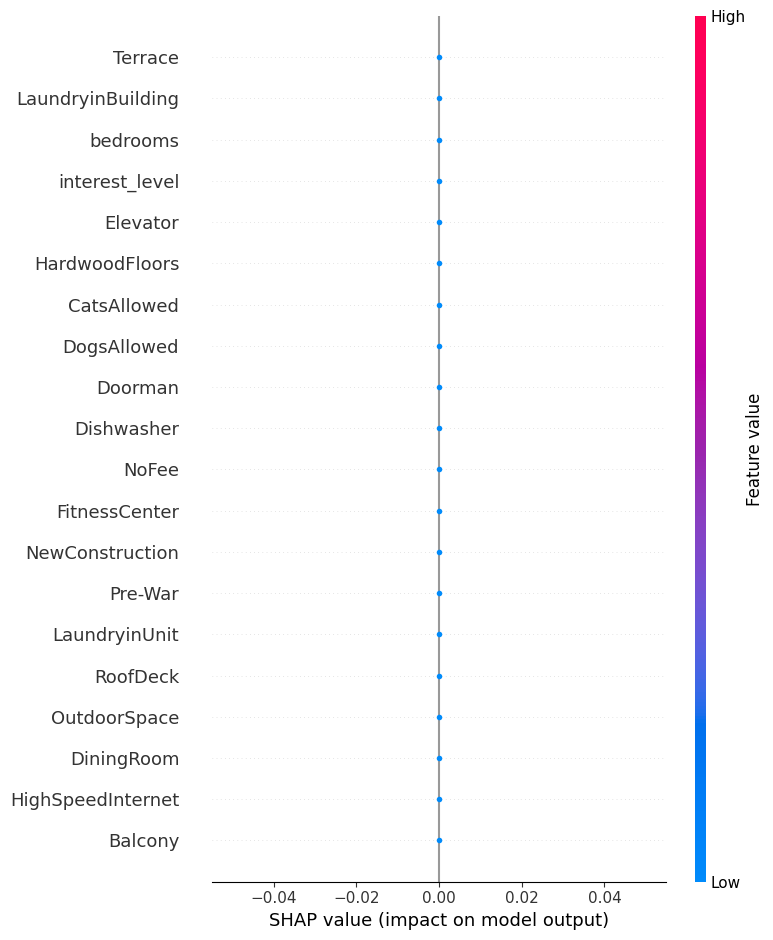

In [373]:
shap.summary_plot(shap_values, instance, feature_names=X_train.columns)

стало хуже

In [374]:
result_MAE.loc[len(result_MAE)] = ['lasso_shap_top10', val_mae_top10,
                                 mean_absolute_error(y_test, lasso_top_10.predict(X_top_10_test))]
result_RMSE.loc[len(result_RMSE)] = ['lasso_shap_top10', val_rmse_top10,
                                   np.sqrt(mean_squared_error(y_test, lasso_top_10.predict(X_top_10_test)))]
result_R2.loc[len(result_R2)] = ['lasso_shap_top10', val_r2_top10,
                                     r2_score(y_test, lasso_top_10.predict(X_top_10_test))]

## 6.5 Compare the quality of these methods for different sides – speed, metrics and stability.

In [375]:
result_MAE

,model,validation,test
0,lasso_default,914.671058,1442.160323
1,lasso_weight_top10,912.260258,1429.962733
2,lasso_corr_top10,959.258398,1472.273293
3,lasso_permutation_top10,906.818075,1436.862549
4,lasso_shap_top10,1069.715249,1596.299359


In [376]:
result_RMSE

,model,validation,test
0,lasso_default,1983.106084,45693.955956
1,lasso_weight_top10,1992.851015,45701.590662
2,lasso_corr_top10,2028.735349,45708.191385
3,lasso_permutation_top10,1981.130874,45696.197996
4,lasso_shap_top10,2286.680776,45696.715928


In [377]:
result_R2

,model,validation,test
0,lasso_default,0.445462,0.001661
1,lasso_weight_top10,0.439999,0.001327
2,lasso_corr_top10,0.419650,0.001039
3,lasso_permutation_top10,0.446566,0.001563
4,lasso_shap_top10,0.262689,0.001541


Best models:  
    - MAE: lasso_permutation_top10  
    - RMSE: lasso_permutation_top10  
    - R2 : lasso_permutation_top10  
    - execution time: lasso_weight_top10

# 7. Hyperparameters optimization

## 7.1 Implement grid search and random search methods for alpha and l1_ratio for ElasticNet model from sklearn.
## 7.2 Find the best combination for the model hyperparameters.

In [380]:
%%time
elastic_net = ElasticNet()

param_grid = {
    'alpha': [0.1, 0.5, 1.0],
    'l1_ratio': [0.25, 0.5, 0.75]
}

grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

CPU times: user 2.04 s, sys: 2.24 s, total: 4.28 s
Wall time: 3.38 s


GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.1, 0.5, 1.0],
                         'l1_ratio': [0.25, 0.5, 0.75]})

In [381]:
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'alpha': 0.1, 'l1_ratio': 0.5}
Best Cross-Validation Score: 0.3507167528489009


In [384]:
param_dist = {
    'alpha': [0.1, 0.5, 1.0],
    'l1_ratio': [0.25, 0.5, 0.75]
}

random_search = RandomizedSearchCV(estimator=elastic_net, param_distributions=param_dist, n_iter=5, cv=5)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=ElasticNet(), n_iter=5,
                   param_distributions={'alpha': [0.1, 0.5, 1.0],
                                        'l1_ratio': [0.25, 0.5, 0.75]})

In [385]:
# Вывод наилучших гиперпараметров и оценки
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'l1_ratio': 0.5, 'alpha': 0.1}
Best Cross-Validation Score: 0.3507167528489009


## 7.3 Fit resulted model.

In [386]:
elastic_net_final = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net_final.fit(X_train, y_train)

ElasticNet(alpha=0.1)

## 7.4 Import optuna and configure the same experiment with ElasticNet.

In [396]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0.001, 1.0, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)

    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    mse = mean_squared_error(y_val, y_pred)
    return mse

## 7.5 Estimate metrics and compare these approaches.

In [397]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-03-07 13:38:06,191] A new study created in memory with name: no-name-a2318d6a-765c-4cf5-9e38-d57b4068124f
[I 2024-03-07 13:38:06,235] Trial 0 finished with value: 3925218.217511233 and parameters: {'alpha': 0.18887116113138988, 'l1_ratio': 0.713527558087834}. Best is trial 0 with value: 3925218.217511233.
[I 2024-03-07 13:38:06,384] Trial 1 finished with value: 3922486.193149342 and parameters: {'alpha': 0.012102784054485416, 'l1_ratio': 0.021593212393785755}. Best is trial 1 with value: 3922486.193149342.
[I 2024-03-07 13:38:06,444] Trial 2 finished with value: 3945038.8852415816 and parameters: {'alpha': 0.9743410928213357, 'l1_ratio': 0.9103845849220173}. Best is trial 1 with value: 3922486.193149342.
[I 2024-03-07 13:38:06,614] Trial 3 finished with value: 3929807.249952797 and parameters: {'alpha': 0.015456218683886443, 'l1_ratio': 0.7280450676870613}. Best is trial 1 with value: 3922486.193149342.
[I 2024-03-07 13:38:06,746] Trial 4 finished with value: 3922690.453202607 

In [398]:
best_params = study.best_params
best_mse = study.best_value

print("Best Hyperparameters:", best_params)
print("Best MSE:", best_mse)

Best Hyperparameters: {'alpha': 0.05183181895640024, 'l1_ratio': 0.4843515485268546}
Best MSE: 3918130.048642026


## 7.6 Run optuna on one of the cross validation schemes

In [400]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0.001, 1.0, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)

    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

    scores = cross_val_score(model, X_train, y_train, cv=5)
    return scores.mean()

In [401]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-03-07 13:55:35,840] A new study created in memory with name: no-name-3f2cb051-fe3d-46a0-a1ac-97ec0f78709a
[I 2024-03-07 13:55:36,754] Trial 0 finished with value: 0.34697074919299836 and parameters: {'alpha': 0.008626338994589429, 'l1_ratio': 0.38461963197217464}. Best is trial 0 with value: 0.34697074919299836.
[I 2024-03-07 13:55:37,041] Trial 1 finished with value: 0.32241252843082846 and parameters: {'alpha': 0.7240966596508223, 'l1_ratio': 0.33984568945501614}. Best is trial 0 with value: 0.34697074919299836.
[I 2024-03-07 13:55:38,729] Trial 2 finished with value: 0.34645593356491017 and parameters: {'alpha': 0.0047552612916381964, 'l1_ratio': 0.3185174469946861}. Best is trial 0 with value: 0.34697074919299836.
[I 2024-03-07 13:55:39,071] Trial 3 finished with value: 0.3504831275174918 and parameters: {'alpha': 0.51285706970039, 'l1_ratio': 0.8571504228119159}. Best is trial 3 with value: 0.3504831275174918.
[I 2024-03-07 13:55:39,329] Trial 4 finished with value: 0.3267

In [402]:
best_params = study.best_params
best_mse = study.best_value

print("Best Hyperparameters:", best_params)
print("Best CVS:", best_mse)

Best Hyperparameters: {'alpha': 0.476391392969094, 'l1_ratio': 0.8894088965602138}
Best CVS: 0.350739858419917
